# Importing data from IS-Academia

We first set up our environment by importing required modules

In [1]:
import pandas as pd
from bs4 import BeautifulSoup as BSoup
from IPython.display import Image
import urllib.request, time, random
#import html5lib

## Understanding IS-Academia

To make automatic requests to IS-Academia, we need to understand how to pass it requests and  find the values of the request parameters we're interested in.

We use Postman to sniff the requests and find the parameters we'll need to play with.

We highlight these paramets in the Postman screenshot below

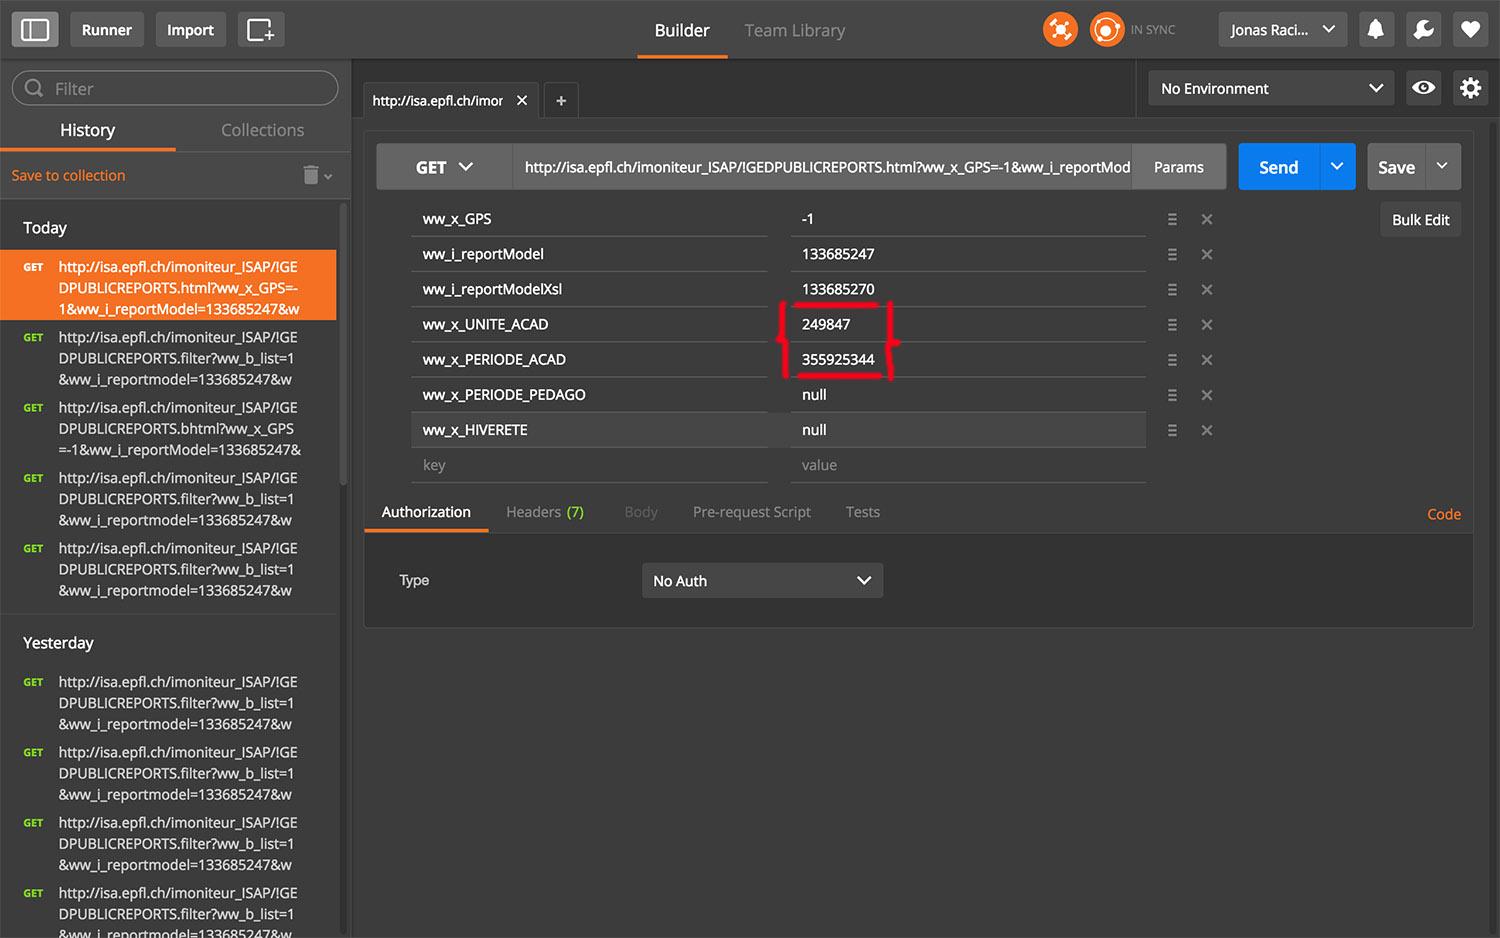

In [2]:
Image(filename='assets/postman.jpg')

The parameters are:
* **ww_x_GPS**: is used to select a student list when the request returns several, -1 allows us to display all the lists in the same table
* **ww_i_reportModel**: is constant, same for **ww_i_reportModelXsl**
* **ww_x_UNITE_ACAD**: is used to select a section (eg. 'Informatique')
* **ww_x_PERIODE_ACAD**: is used to select the academic period (eg. '2016-2017')
* we set **ww_x_PERIODE_PEDAGO** and **ww_x_HIVERETE** to 'null' to get all students enrolled in the section, regardless of their semester

## Preparing the requests

The IS-Academia form is hard to reach with Beautiful Soup (seems dynamically generated), so we copied its html and saved it to a file

In [3]:
form = 'assets/isform.html'

In [4]:
with open(form, 'r') as html:
    r = html.read()
soup = BSoup(r, 'lxml')

To find the values we use beautiful soup to parse the form

The values are encoded in the html 'option' tag that lists the choices the user can select

In [5]:
options = soup.find_all('option')

We extract the name of the option and its parameter value and combine it in a DataFrame

In [6]:
values = []
names = []

In [7]:
for opt in options:
    v = opt['value']
    n = opt.get_text()
    if opt['value'] != 'null' or 1:
        values.append(v)
        names.append(n)

In [8]:
df = pd.DataFrame({'values': values, 'names': names})

Per section and per period we will extract all students at once, so we only need section and period values. We thus split our DataFrame accordingly

In [9]:
subjects = df[1:20]
years = df[21:31]
subjects.head(5)

,names,values
1,Architecture,942293
2,Chimie et génie chimique,246696
3,Cours de mathématiques spéciales,943282
4,EME (EPFL Middle East),637841336
5,Génie civil,942623


In [10]:
years.head(5)

,names,values
21,2016-2017,355925344
22,2015-2016,213638028
23,2014-2015,213637922
24,2013-2014,213637754
25,2012-2013,123456101


Finally, in this exercise we only consider 'Informatique', so we keep only that row

In [11]:
subjects = subjects.loc[subjects.names == 'Informatique']

## Requesting, cleaning and combining data from IS-Academia

This whole process is abstracted in our ISA() class. We refer you to the inline comments of its \_\_init\_\_ function to understand the various steps of the process.

In [12]:
class ISA():
    """ this class is used to build a usable DataFrame from a request to IS-Academia 
    
    Args:
        name (str): name of EPFL section
        period (str): academic period (years)
        subj (str): the value code for EPFL section
        year (str): the value code for academic period
        season (str): the value code for winter/spring semester
        semester (str): the value code for semester
    
    Attributes:
        fileName (str): file name for saving
        url (str): the parametrized url for 
        soup (str): souped up requested HTML
        hasContent (bool): bool to check that request isn't empty
        tables (array of strings): list of HTML subtables, None if !hasContent
        frames (array of DataFrames): list of DataFrames of subtables, None if !hasContent
        hasFrames (bool): bool to check that object does have a frame (see inline comment)
        bigFrame (DataFrame): final concatenated and reindexed DataFrame, None if !hasFrames
    """
    # ISA base url and save folder
    baseUrl = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270'
    folder = 'data/'
    
    ################################
    #### Initializing functions ####
    ################################
    
    def getFileName(self, name, period):
        """ used to prepare the file name for saving
        
        Args:
            name (str): the name of EPFL section
            period (str): the academic period (years)
            
        Returns:
            str: underscored concatenated name
        
        """
        name = name.lower()
        name = name.replace(' ', '_')
        period = period.replace('-', '_')
        return name+'_'+period
    
    def getUrl(self, subj, year, season, semester):
        """ Builds the request url
        
        Args:
            subj (str): the value code for EPFL section
            year (str): the value code for academic period
            season (str): the value code for winter/spring semester
            semester (str): the value code for semester
            
        Returns:
            str: url with appropriate parameters
        """
        paramSubj = '&ww_x_UNITE_ACAD='+subj
        paramYear = '&ww_x_PERIODE_ACAD='+year
        paramSemester = '&ww_x_PERIODE_PEDAGO='+semester
        paramSeason = '&ww_x_HIVERETE='+season
        url = self.baseUrl+paramSubj+paramYear+paramSemester+paramSeason
        return url
    
    def getSoup(self, url):
        """ makes request and gets souped HTML 
        
        Args:
            url (str): proper url for request
            
        Returns:
            BSoup object: souped up HTML
        """
        with urllib.request.urlopen(url) as html:
            r = html.read()
        return BSoup(r, 'lxml')
    
    ################################
    
    ###################################
    #### HTML parsing and cleaning ####
    ###################################
    
    def tableToList(self, soup):
        """ transforms html table into list of rows (BSoup objects) 
        
        Args:
            soup (BSoup object): souped up HTML
            
        Returns:
            array of BSoup objects: list of table rows
        """
        return soup.find('table').find_all('tr')
    
    def cleanHTMLTable(self, tr):
        """ takes row list and returns pandas usable table, gets rid of the initial title row
        
        Args:
            tr (array of BSoup objects): list of table rows
            
        Returns:
            str: HTML table in a string
        """
        # Replacing the title row with a <table> tag. The title info will
        # be added as a column of the DataFrame
        tr[0] = '<table>'
        # Initialize str
        table = ''
        # Looping through rows and filling the table str
        for t in tr:
            table += str(t)
        # Closing the table
        table += '</table>'
        return table
    
    ###################################

    ##########################################
    #### Data handling and transformation ####
    ##########################################
    
    # we have a table for the whole section, but it is made of smaller semester-specific tables
    # concatenated together. we separate them with this function
    def sepTables(self, soup):
        """ fills an array with subtables of our original table 
        
        Args:
            soup (BSoup object): souped up HTML
            
        Returns:
            array of arrays of strings: list of ['subtable name', 'subtable (str)']
        """
        
        # initializing array
        tables = []
        
        # transforming the table into list of rows for manipulation
        table = self.tableToList(soup)
        
        # we want to extract subtables, so with an outer loop we find subtable header,
        # initialize a subtable and use an inner loop to fill it
        
        # start the outer loop
        for idx, row in enumerate(table):
            # test for subtable headers (they're the only ones with 'colspan')
            if str(row).find('colspan') != -1:
                
                # we use the header text to name our subtable
                text = row.get_text()
                # we clean it
                name = text[:text.find(u'\n')]
                
                # initialize subtable array
                subtable = [row]
                # i is used to loop through subtable rows, starting below header
                i = idx+1
                # we check that we're not already at the end of table (eg empty subtable)
                if i < len(table):
                    # inner loop, checking we haven't reached a new subtable header
                    while str(table[i]).find('colspan') == -1:
                        subtable.append(table[i])
                        i += 1
                        # break if we reach end of table
                        if i == len(table):
                            break
                # if subtable was empty, nullify it
                if len(subtable) == 1:
                    subtable = 'null'
                # we add the subtable to our tables array
                tables.append([name, subtable])

        return tables
    
    # we transform each table into a frame
    def tableToFrame(self, name, table):
        """ takes a ISA html table and returns a DataFrame 
        
        Args:
            name (str): the name of the table section
            table (str): HTML table
            
        Returns:
            DataFrame: cleaned DataFrame object for that table with name as added column 
        """
        # getting a clean HTML table with no title header
        t = self.cleanHTMLTable(table)
        # putting it in a dataframe
        df = pd.read_html(t, header=0)
        
        # the dataframe we're looking for is somehow encapsulated so we retrieve it
        df = df[0]
        # getting rid of an unwanted column
        df = df.drop('Unnamed: 11', axis=1)
        
        # adding a column with student type, this is where we store this information
        df['type'] = name

        return df
    
    # we loop through the HTML tables we have to transform them into frames
    def tablesToFrames(self, tables):
        """ fills an array with DataFrames corresponding to the HTML subtables the tables array
        
        Args:
            tables (array of arrays): list of ['subtable name', 'subtable (str)']
            
        Returns:
            array of DataFrames: list of DataFrames corresponding to the tables
        """
        frames = []
        
        for t in tables:
            name = t[0]
            table = t[1]     
            # skips subtables with no content
            if table != 'null':
                frame = self.tableToFrame(name, table)
                frames.append(frame)
                
        return frames
    
    # finally we concatenate everything into a big frame
    def concatFrames(self, frames):
        """ returns a frame made of all subframes concatenated and reindexed 
        
        Args:
            frames (array of DataFrames): list of DataFrames
            
        Returns:
            DataFrame: final DataFrame with concatenated and reindexed subframes
        """
        # make final df
        final = frames[0]
        for frame in frames[1:]:
            final = pd.concat([final, frame], axis=0)

        # we reset index to have an index over the whole complete frame
        final = final.reset_index().drop('index', axis=1)
        
        return final
    
    ##########################################
        
    ########################
    #### Initialization ####
    ########################
    def __init__(self, name, period, subj, year, season, semester):
        """ Initializes and builds HTML subtables, sub-DataFrames and final DataFrames
        
        Args:
            name (str): name of EPFL section
            period (str): academic period (years)
            subj (str): the value code for EPFL section
            year (str): the value code for academic period
            season (str): the value code for winter/spring semester
            semester (str): the value code for semester
        """
        # REQUESTING #
        # Getting a clean file name for saving
        self.fileName = self.getFileName(name, period)
        # Getting the request url
        self.url = self.getUrl(subj, year, season, semester)
        # Getting the request HTML as a BSoup object
        self.soup = self.getSoup(self.url)
        
        # WRANGLING #
        # we use the functions above to prepare the data
        
        # check that the request didn't come back empty
        self.hasContent = len(self.tableToList(self.soup)) > 1
        if self.hasContent:
            # Separating the BSoup HTML into HTML subtables
            self.tables = self.sepTables(self.soup)
            # Transforming the HTML subtables into DataFrames
            self.frames = self.tablesToFrames(self.tables)
        else:
            self.tables = None
            self.frames = None
            
        # check that there actually is a frame
        # there is no frame when: request didn't come back empty but contained only
        # empty subtables (more than one) (eg master humanites digitales I think)
        self.hasFrames = self.frames != None and (len(self.frames) > 0)        
        if self.hasFrames:
            # concatenate everything into a final reindexed DataFrame
            self.bigFrame = self.concatFrames(self.frames)
        else:
            self.bigFrame = None
            
    ########################
    
    ################       
    #### Saving ####
    ################
    def save(self):
        """ saves the final DataFrame to a file with fileName
        
            prints along to keep track
        """
        # Checking that there is something to save
        if self.hasFrames:
            # Exporting to csv w/out index to avoid unnamed column when later reading file
            self.bigFrame.to_csv(self.folder+self.fileName+'.csv', sep=',', encoding='utf-8', index=False)
            # Printing something to keep track
            print('saved '+self.fileName+' to '+self.folder)
        else:
            # Announcing nothing has been saved
            print(self.fileName+' has no content')

## Retrieving the data

We use a loop to retrieve and save the IS-Academia records. In this exercise, 'subjects' is only 'Informatique', but the loop can be used to retrieve records throughouts subjects.

We set season and semester to null, since we're not this specific in our requests

In [13]:
season = 'null'
semester = 'null'

In [14]:
def isaLoop(subjects, years):
    """ loops through subject (outer) and years (inner) to collect and save ISA data
    
    Args:
        subjects (DataFrame): frame containing all EPFL sections with names and param values
        years (DataFrame): frame containing academic periods with names and param values
        
    Returns:
        saves final DataFrame to file
    """
    # start looping through subjects
    for row in subjects.iterrows():
        o = row[1]
        name = o['names']
        subj = o['values']
        
        # loop through years
        for r in years.iterrows():
            q = r[1]
            period = q['names']
            year = q['values']
            
            data = ISA(name, period, subj, year, season, semester)
            data.save()
            
        # we set a small randomized waiting time to look less bot-like
        time.sleep(round(random.uniform(1.5, 5),2))
            
    print('all done my man')

In [15]:
isaLoop(subjects, years)

saved informatique_2016_2017 to data/
saved informatique_2015_2016 to data/
saved informatique_2014_2015 to data/
saved informatique_2013_2014 to data/
saved informatique_2012_2013 to data/
saved informatique_2011_2012 to data/
saved informatique_2010_2011 to data/
saved informatique_2009_2010 to data/
saved informatique_2008_2009 to data/
saved informatique_2007_2008 to data/
all done my man
